### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, roc_curve, auc,
                             precision_recall_curve)
from sklearn.model_selection import GridSearchCV, learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

### Model Selection

- Uses **TF-IDF vectorization** for text feature extraction.  
- Implements multiple **ML models** (Naive Bayes, SVM, Logistic Regression, Neural Network, Random Forest).  
- Optimizes models using **GridSearchCV** for hyperparameter tuning.  
- Evaluates models with **accuracy, confusion matrix, ROC, and Precision-Recall curves**.  
- Checks for **overfitting/underfitting** using learning curves and score comparison.  
- Analyzes **data drift** between training and test sets.  
- Selects the **best model**, saves it, and ranks all models based on performance.

In [4]:
class ModelTraining:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=3000,
            ngram_range=(1, 2),
            stop_words='english',
            strip_accents='unicode',
            preprocessor=str,
            min_df=3,
            max_df=0.9
        )

        self.models = {
            'naive_bayes': {
                'model': MultinomialNB(),
                'params': {
                    'classifier__alpha': [0.5, 1.0, 2.0],
                }
            },
            'bernoulli_nb': {
                'model': BernoulliNB(),
                'params': {
                    'classifier__alpha': [0.5, 1.0, 2.0],
                }
            },
            'svm_rbf': {
                'model': SVC(random_state=42, probability=True),
                'params': {
                    'classifier__C': [0.5, 1.0],
                    'classifier__gamma': ['scale', 'auto'],
                    'classifier__kernel': ['rbf'],
                    'classifier__class_weight': ['balanced']
                }
            },
            'logistic_regression': {
                'model': LogisticRegression(random_state=42),
                'params': {
                    'classifier__C': [0.1, 0.5, 1.0],
                    'classifier__solver': ['liblinear'],
                    'classifier__class_weight': ['balanced'],
                    'classifier__penalty': ['l1', 'l2']
                }
            },
            'neural_network': {
                'model': MLPClassifier(random_state=42),
                'params': {
                    'classifier__hidden_layer_sizes': [(32,), (64,), (128,), (32, 16), (64, 32)],
                    'classifier__activation': ['relu', 'tanh'],
                    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
                    'classifier__learning_rate': ['constant', 'adaptive'],
                    'classifier__early_stopping': [True, False],
                    'classifier__validation_fraction': [0.1, 0.2],
                    'classifier__max_iter': [300, 500]
                }
            },
            'random_forest': {
                'model': RandomForestClassifier(random_state=42),
                'params': {
                    'classifier__n_estimators': [100, 200],
                    'classifier__max_depth': [10, 20, 30, 50, 100],
                    'classifier__min_samples_split': [2, 5, 10],
                    'classifier__min_samples_leaf': [1, 2, 4],
                    'classifier__max_features': ['sqrt', 'log2'],
                    'classifier__bootstrap': [True, False],
                    'classifier__class_weight': ['balanced', 'balanced_subsample']
                }
            },
        }

        self.best_model = None
        self.best_score = 0

    def create_pipeline(self, model):
        """Create a pipeline with TF-IDF and model"""

        return Pipeline([
            ('tfidf', self.vectorizer),
            ('classifier', model)
        ])

    def plot_learning_curves(self, estimator, X, y, title):
        train_sizes, train_scores, val_scores = learning_curve(
            estimator, X, y, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10)
        )

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
        plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
        plt.xlabel('Training examples')
        plt.ylabel('Score')
        plt.title(f'Learning Curves - {title}')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

    def plot_roc_curve(self, model, X, y, title):
        """Plot ROC curve"""
        try:
            if not hasattr(model, "predict_proba"):
                print(f"Warning: {type(model).__name__} doesn't support predict_proba")
                return

            y = y.astype(int)
            y_score = model.predict_proba(X)[:, 1]

            fpr, tpr, _ = roc_curve(y, y_score)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(10, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {title}')
            plt.legend(loc='best')
            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"Could not generate ROC curve for {title}: {str(e)}")

    def plot_precision_recall_curve(self, model, X, y, title):
        """Plot precision-recall curve"""
        try:
            if not hasattr(model, "predict_proba"):
                print(f"Warning: {type(model).__name__} doesn't support predict_proba")
                return

            y = y.astype(int)
            y_score = model.predict_proba(X)[:, 1]

            precision, recall, _ = precision_recall_curve(y, y_score)

            plt.figure(figsize=(10, 6))
            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve - {title}')
            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"Could not generate Precision-Recall curve for {title}: {str(e)}")

    def evaluate_model(self, pipeline, X, y, dataset_name=""):
        """Enhanced model evaluation"""
        try:
            y = pd.Series(y).astype(int)

            y_pred = pipeline.predict(X)

            accuracy = accuracy_score(y, y_pred)
            report = classification_report(y, y_pred,
                                           target_names=['ham', 'spam'],
                                           output_dict=True)

            # Plot confusion matrix
            plt.figure(figsize=(10, 8))
            cm = confusion_matrix(y, y_pred)
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                        xticklabels=['ham', 'spam'],
                        yticklabels=['ham', 'spam'])
            plt.title(f'Normalized Confusion Matrix - {dataset_name}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()

            # If pipeline supports predict_proba, plot ROC & PR curves
            if hasattr(pipeline, 'predict_proba'):
                self.plot_roc_curve(pipeline, X, y, dataset_name)
                self.plot_precision_recall_curve(pipeline, X, y, dataset_name)

            print(f"\nResults on {dataset_name} set:")
            print(f"Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(classification_report(y, y_pred))

            return accuracy
        except Exception as e:
            print(f"Error in model evaluation: {str(e)}")
            raise

    def analyze_data_drift(self, train_df, test_df):
        print("\nAnalyzing data drift...")
        train_lengths = train_df['processed_text'].str.len()
        test_lengths = test_df['processed_text'].str.len()

        plt.figure(figsize=(10, 6))
        plt.hist(train_lengths, alpha=0.5, label='Train', density=True)
        plt.hist(test_lengths, alpha=0.5, label='Test', density=True)
        plt.title('Text Length Distribution: Train vs Test')
        plt.legend()
        plt.show()

        train_vocab = set(' '.join(train_df['processed_text']).split())
        test_vocab = set(' '.join(test_df['processed_text']).split())
        vocab_overlap = len(train_vocab.intersection(test_vocab)) / len(train_vocab) if len(train_vocab) > 0 else 0
        print(f"Vocabulary overlap between train and test: {vocab_overlap:.2%}")

    def check_model_fit(self, model, X_train, y_train, X_test, y_test):
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)

        print("\nModel Fit Analysis:")
        print(f"Train score: {train_score:.4f}")
        print(f"Test score: {test_score:.4f}")

        if test_score < train_score * 0.9:
            print("Warning: Possible overfitting - test score significantly lower than train score")
        elif train_score < 0.6 and test_score < 0.6:
            print("Warning: Possible underfitting - both train and test scores are low")

        self.plot_learning_curves(model, X_train, y_train, "fit_analysis")

    def train_and_evaluate(self, train_df, val_df, test_df):
        print("Training and evaluating models...")

        combined_df = pd.concat([train_df, val_df], ignore_index=True)
        print(f"\nCombined training set size: {len(combined_df)} samples")

        for df, name in [(combined_df, 'training'), (test_df, 'test')]:
            if 'processed_text' not in df.columns or 'label' not in df.columns:
                raise ValueError(f"Missing required columns in {name} data")

            df['processed_text'] = df['processed_text'].fillna('').astype(str)

            # Convert ham/spam to 0/1 if still strings
            if df['label'].dtype == object:
                print(f"\nConverting labels in {name} set...")
                df['label'] = df['label'].map({'ham': 0, 'spam': 1})
                if df['label'].isna().any():
                    raise ValueError(f"Invalid labels found in {name} data")

            if not set(df['label'].unique()).issubset({0, 1}):
                raise ValueError(f"Invalid label values in {name} data: {df['label'].unique()}")

        n_neg = len(combined_df[combined_df['label'] == 0])
        n_pos = len(combined_df[combined_df['label'] == 1])
        scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
        print(f"\nClass imbalance ratio (ham/spam): {scale_pos_weight:.2f}")

        results = {}

        for model_name, model_info in tqdm(self.models.items()):
            print(f"\nTraining {model_name}...")
            try:
                pipeline = self.create_pipeline(model_info['model'])

                grid_search = GridSearchCV(
                    pipeline,
                    model_info['params'],
                    cv=5,
                    scoring='accuracy',
                    n_jobs=-1
                )

                grid_search.fit(combined_df['processed_text'], combined_df['label'])

                best_pipeline = grid_search.best_estimator_

                train_score = self.evaluate_model(
                    best_pipeline,
                    combined_df['processed_text'],
                    combined_df['label'],
                    f"{model_name}_training"
                )

                test_score = self.evaluate_model(
                    best_pipeline,
                    test_df['processed_text'],
                    test_df['label'],
                    f"{model_name}_test"
                )

                self.plot_learning_curves(
                    best_pipeline,
                    combined_df['processed_text'],
                    combined_df['label'],
                    model_name
                )

                results[model_name] = {
                    'pipeline': best_pipeline,
                    'best_params': grid_search.best_params_,
                    'cv_scores': grid_search.cv_results_['mean_test_score'],
                    'train_score': train_score,
                    'test_score': test_score
                }

                if test_score > self.best_score:
                    self.best_score = test_score
                    self.best_model = best_pipeline
                    self.best_model_name = model_name

                joblib.dump(best_pipeline, f"{model_name}_model.pkl")

                self.check_model_fit(
                    best_pipeline,
                    combined_df['processed_text'],
                    combined_df['label'],
                    test_df['processed_text'],
                    test_df['label']
                )

            except Exception as e:
                print(f"\nError training {model_name}: {str(e)}")
                continue

        print("\nModel Performance Summary:")
        summary_data = []
        for model_name, result in results.items():
            summary_data.append({
                'Model': model_name,
                'Train Accuracy': result['train_score'],
                'Test Accuracy': result['test_score'],
            })

        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('Test Accuracy', ascending=False)
        print("\nModel Rankings (sorted by test accuracy):")
        print(summary_df.to_string(index=False))

        joblib.dump(self.best_model, "final_model.pkl")
        print(f"\nBest model ({self.best_model_name}) saved as 'final_model.pkl'")
        print(f"Best test accuracy: {self.best_score:.4f}")

        # Optional: Data drift analysis
        self.analyze_data_drift(train_df, test_df)

Training and evaluating models...

Combined training set size: 4338 samples

Class imbalance ratio (ham/spam): 6.82


  0%|                                       | 0/6 [00:00<?, ?it/s]


Training naive_bayes...


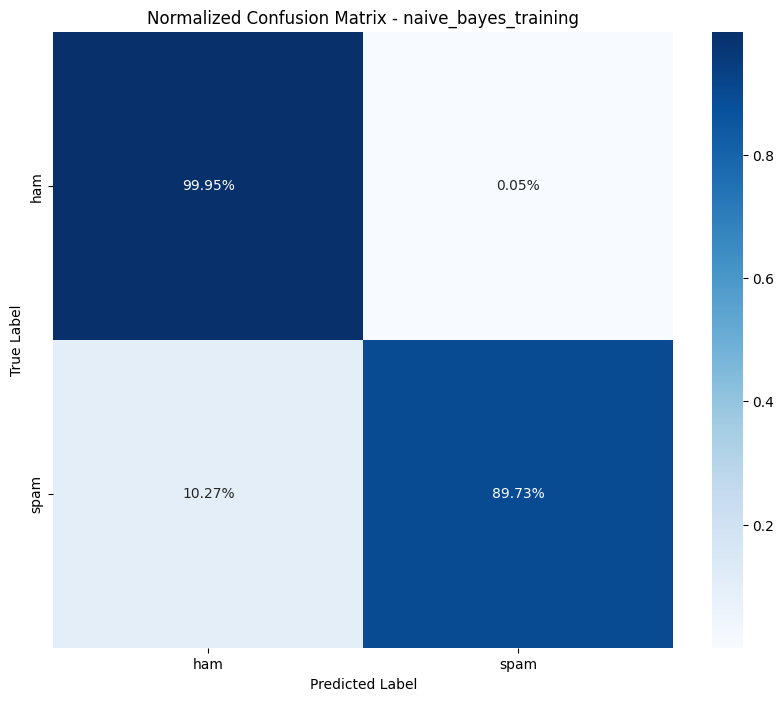

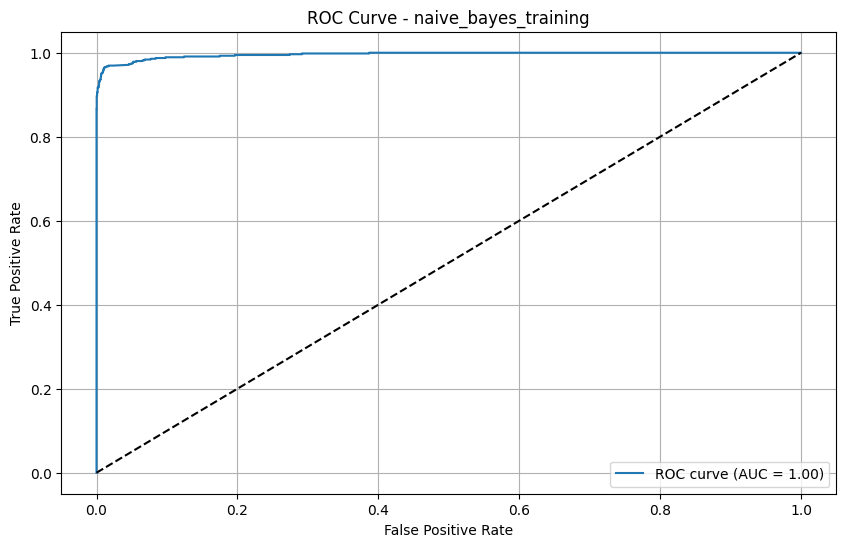

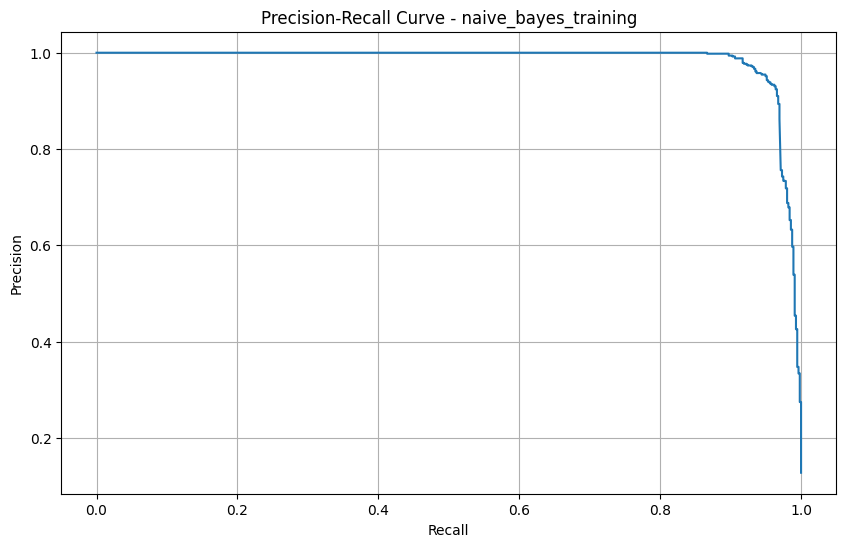


Results on naive_bayes_training set:
Accuracy: 0.9864

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3783
           1       1.00      0.90      0.94       555

    accuracy                           0.99      4338
   macro avg       0.99      0.95      0.97      4338
weighted avg       0.99      0.99      0.99      4338



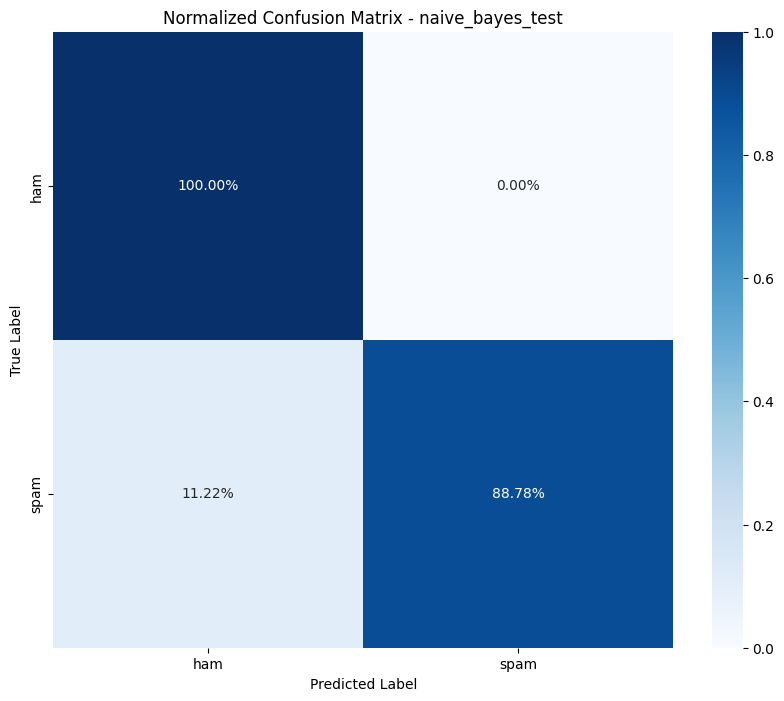

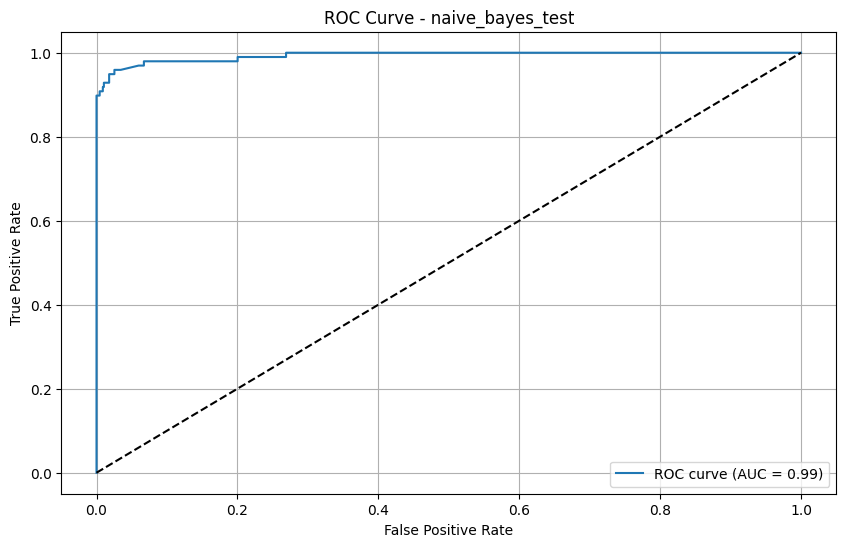

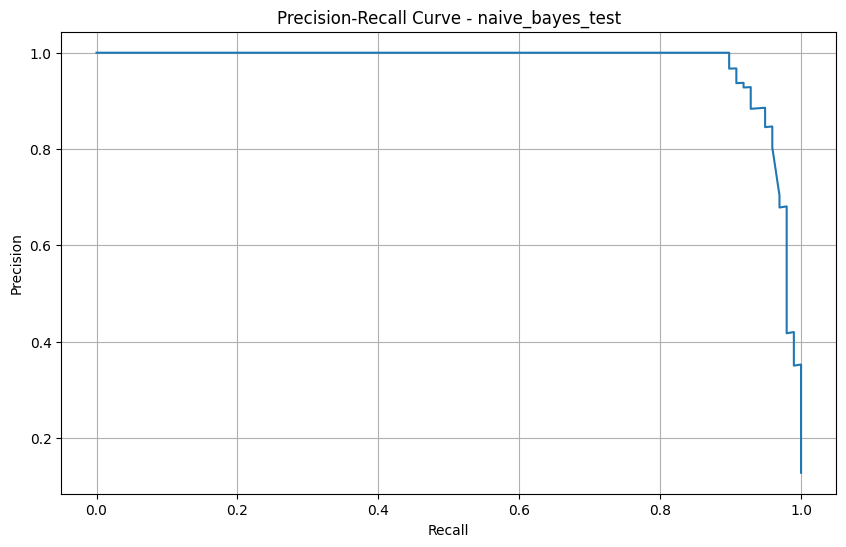


Results on naive_bayes_test set:
Accuracy: 0.9857

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       669
           1       1.00      0.89      0.94        98

    accuracy                           0.99       767
   macro avg       0.99      0.94      0.97       767
weighted avg       0.99      0.99      0.99       767



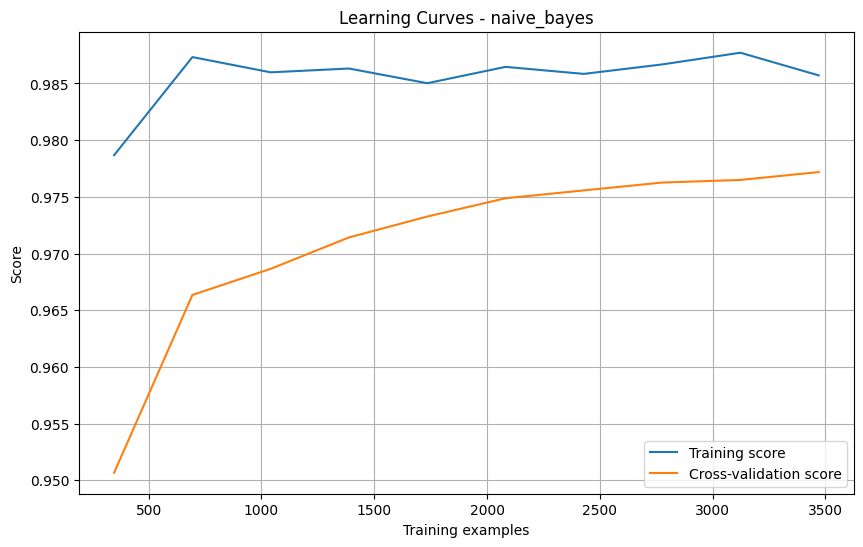


Model Fit Analysis:
Train score: 0.9864
Test score: 0.9857


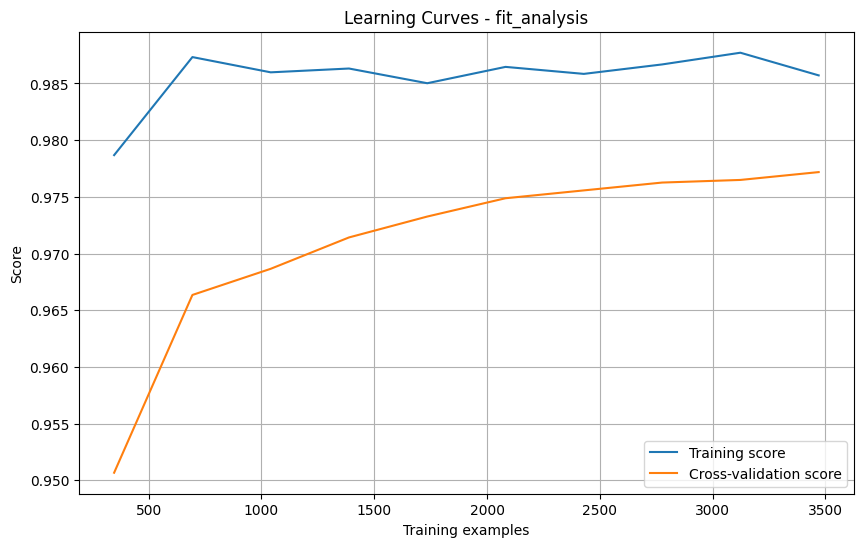

 17%|█████▏                         | 1/6 [00:01<00:09,  1.90s/it]


Training bernoulli_nb...


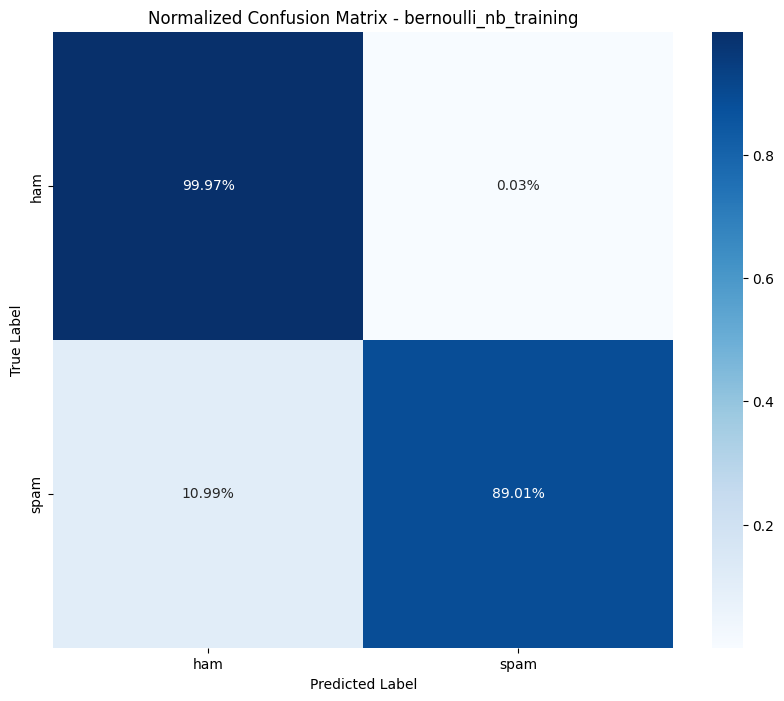

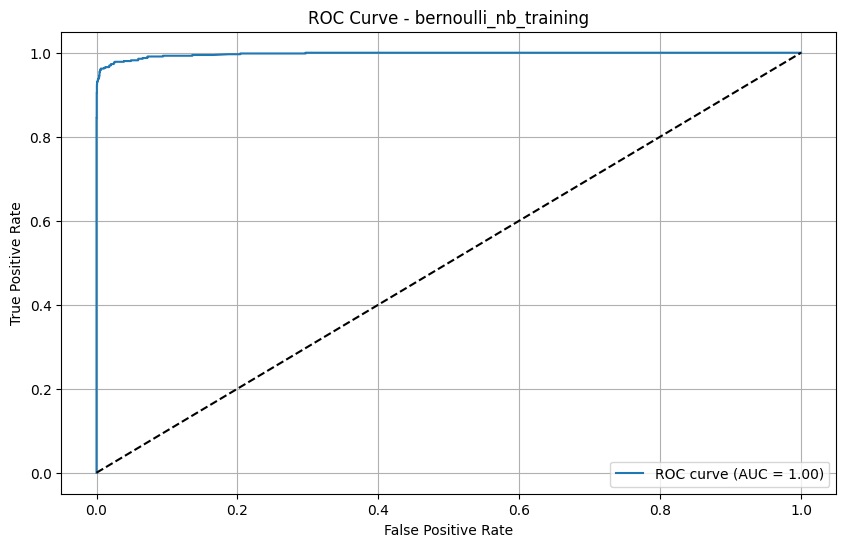

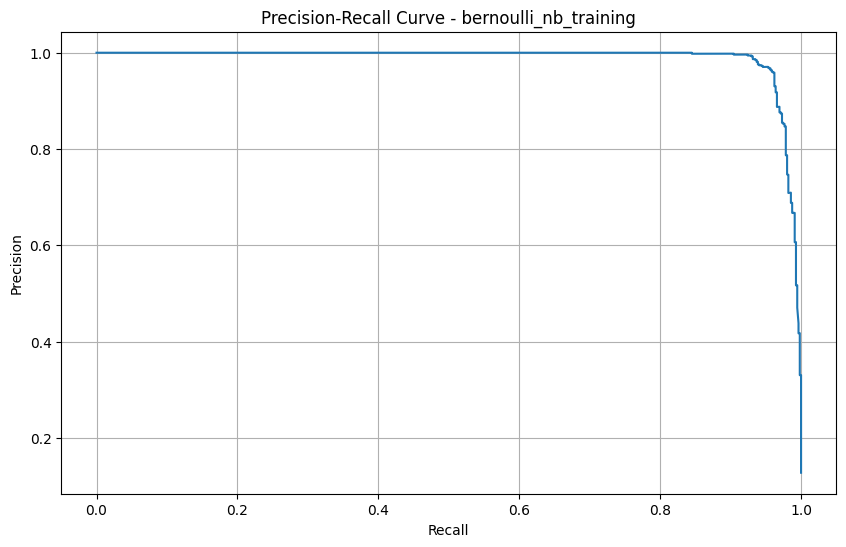


Results on bernoulli_nb_training set:
Accuracy: 0.9857

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3783
           1       1.00      0.89      0.94       555

    accuracy                           0.99      4338
   macro avg       0.99      0.94      0.97      4338
weighted avg       0.99      0.99      0.99      4338



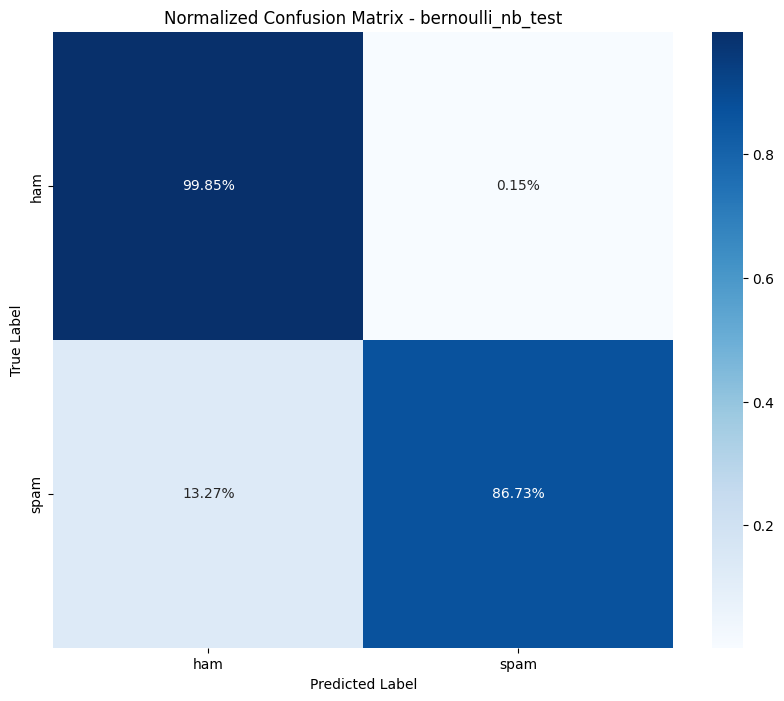

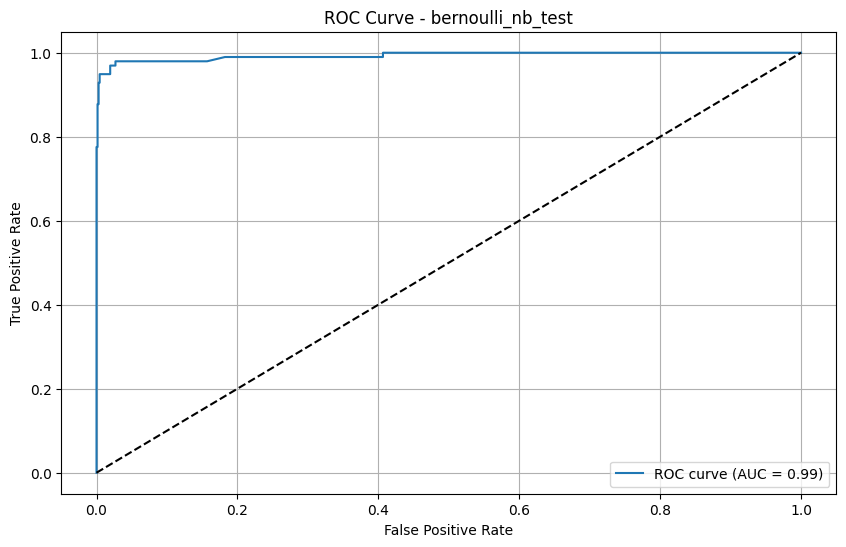

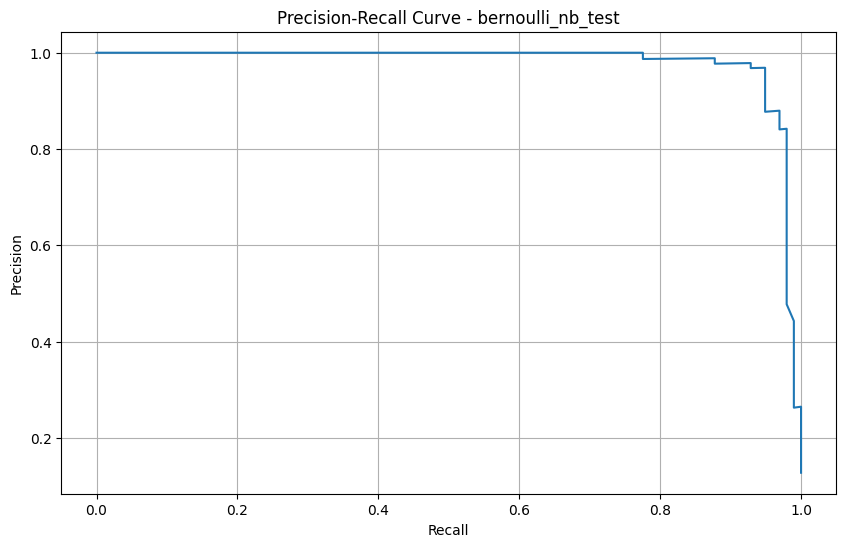


Results on bernoulli_nb_test set:
Accuracy: 0.9817

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       669
           1       0.99      0.87      0.92        98

    accuracy                           0.98       767
   macro avg       0.98      0.93      0.96       767
weighted avg       0.98      0.98      0.98       767



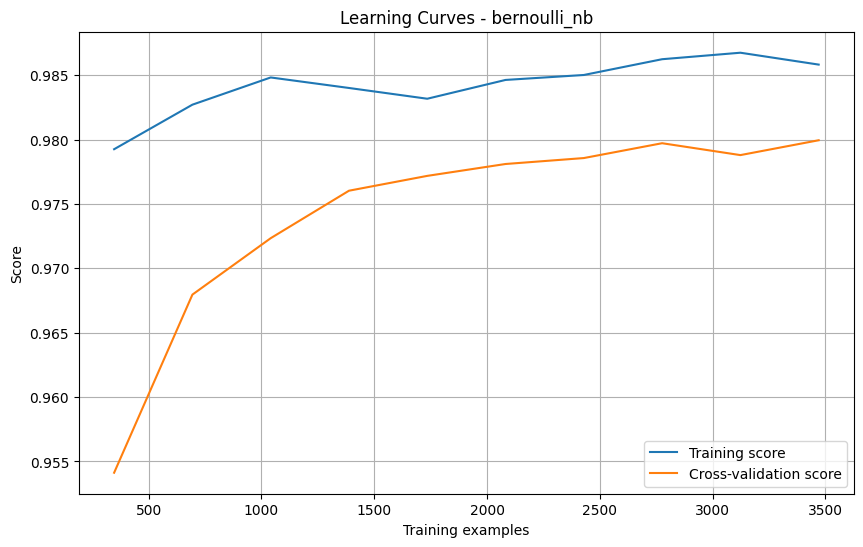


Model Fit Analysis:
Train score: 0.9857
Test score: 0.9817


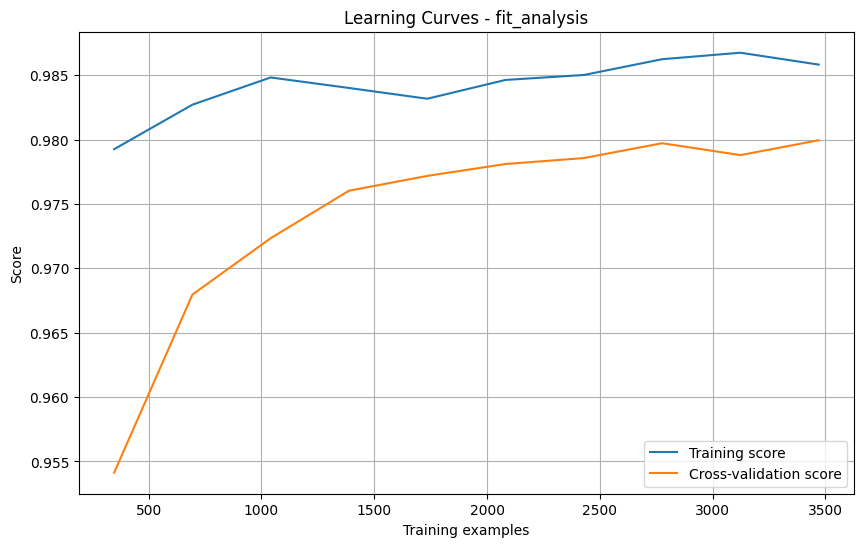

 33%|██████████▎                    | 2/6 [00:03<00:07,  1.92s/it]


Training svm_rbf...


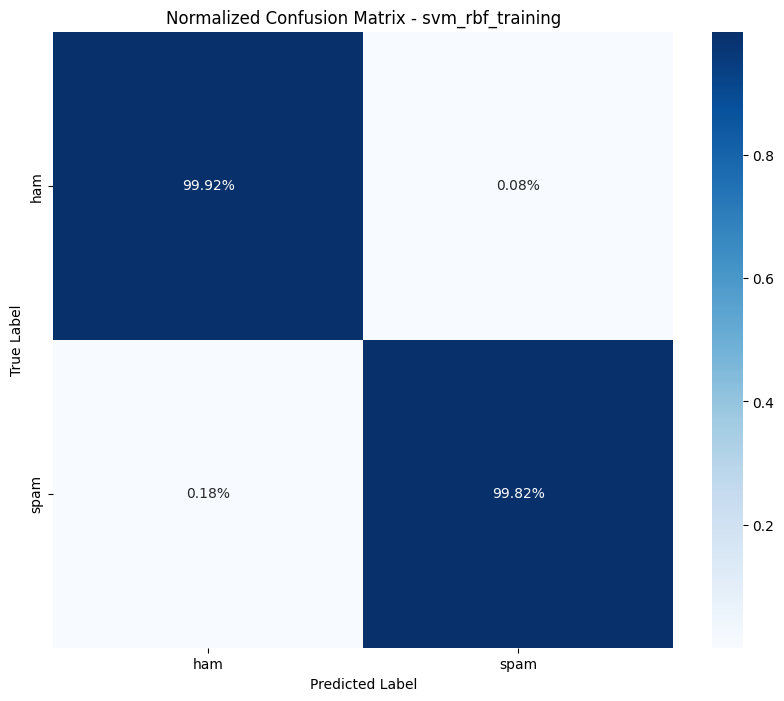

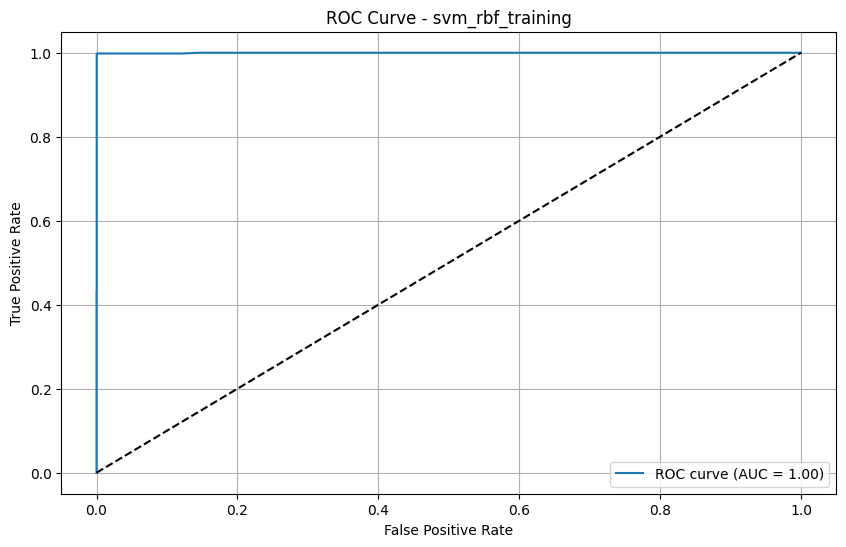

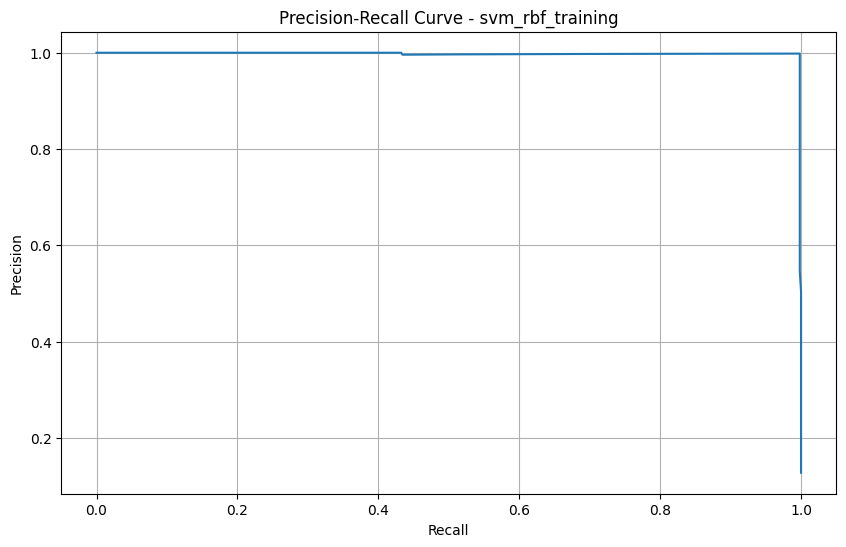


Results on svm_rbf_training set:
Accuracy: 0.9991

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3783
           1       0.99      1.00      1.00       555

    accuracy                           1.00      4338
   macro avg       1.00      1.00      1.00      4338
weighted avg       1.00      1.00      1.00      4338



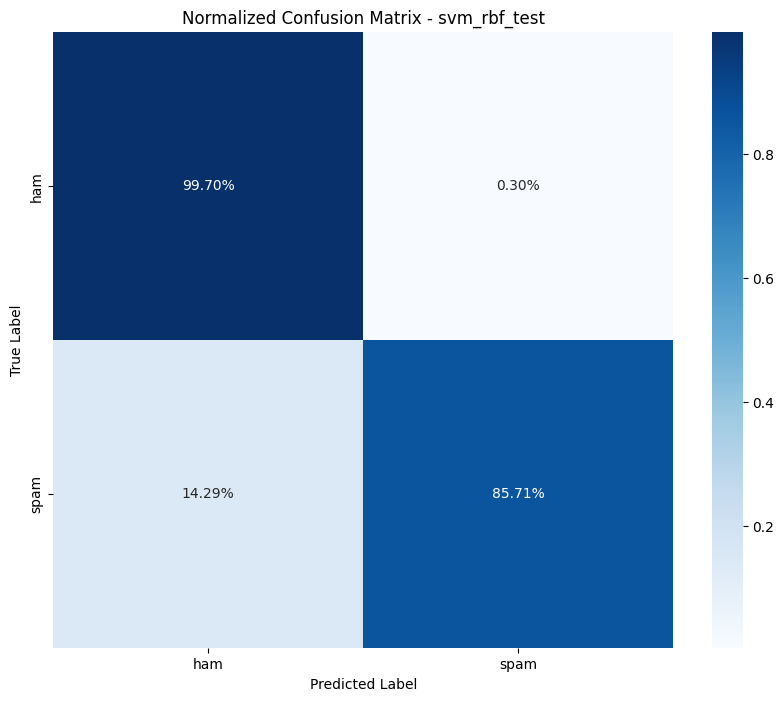

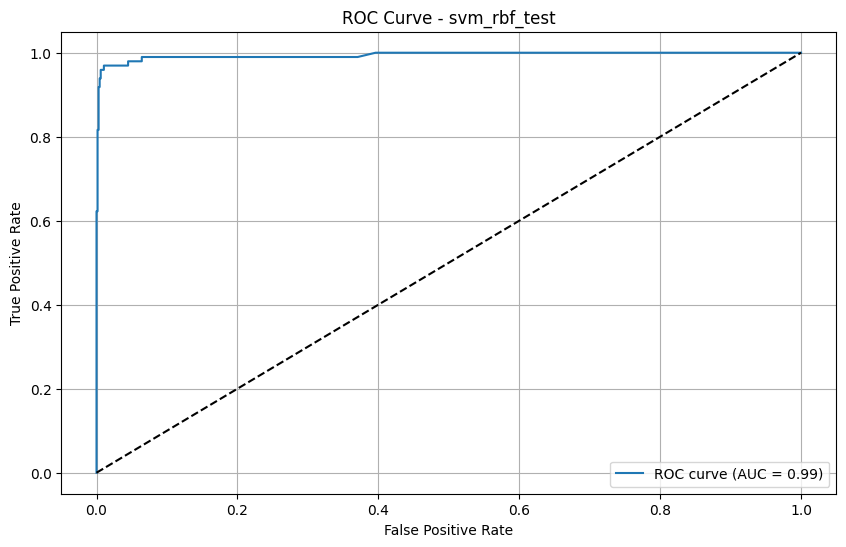

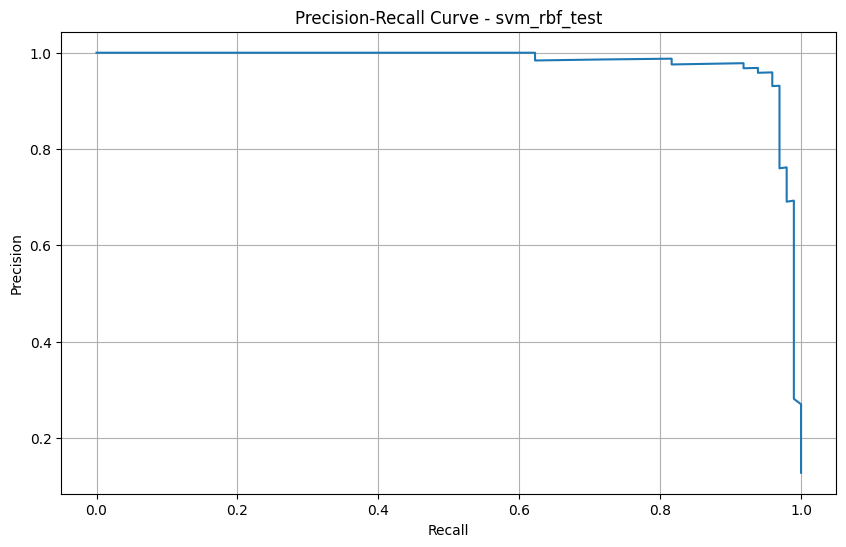


Results on svm_rbf_test set:
Accuracy: 0.9791

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       669
           1       0.98      0.86      0.91        98

    accuracy                           0.98       767
   macro avg       0.98      0.93      0.95       767
weighted avg       0.98      0.98      0.98       767



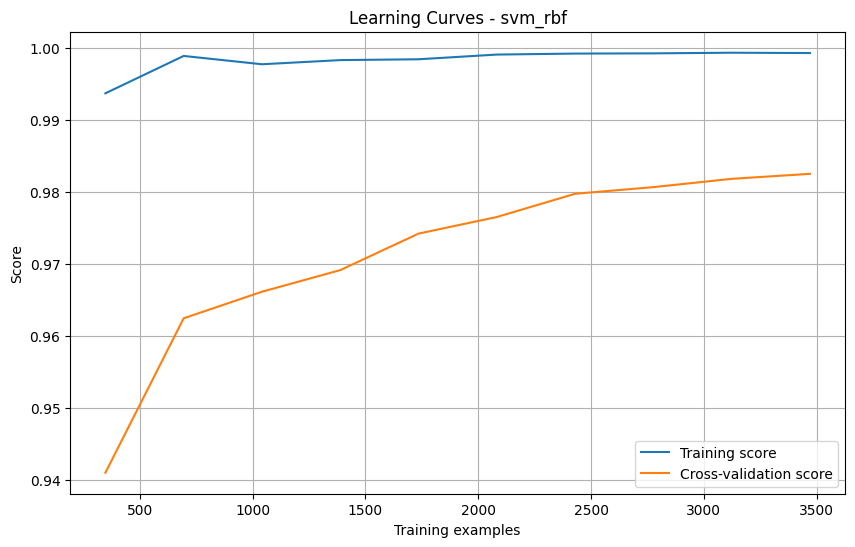


Model Fit Analysis:
Train score: 0.9991
Test score: 0.9791


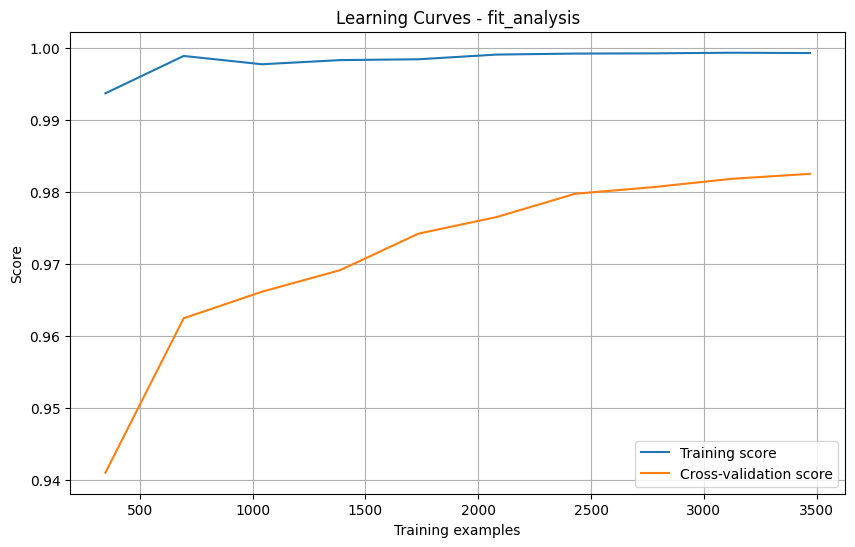

 50%|███████████████▌               | 3/6 [00:21<00:26,  8.96s/it]


Training logistic_regression...


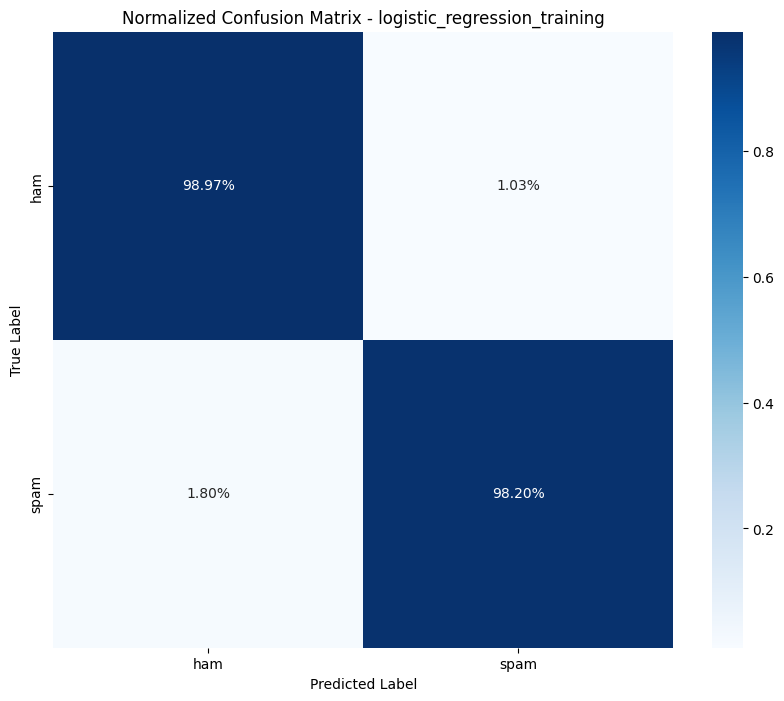

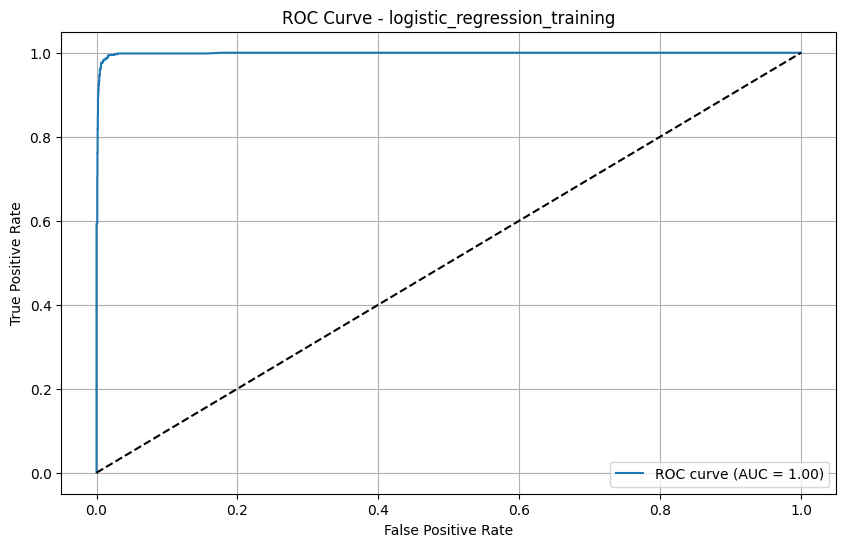

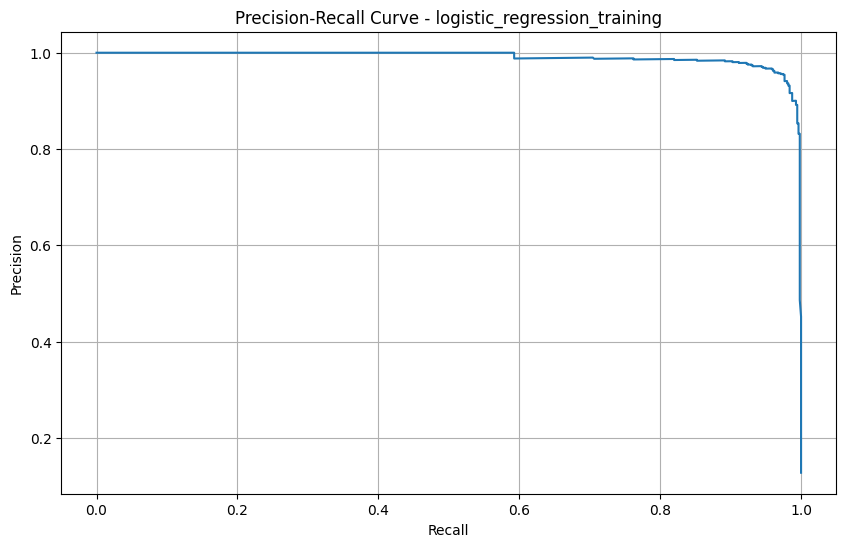


Results on logistic_regression_training set:
Accuracy: 0.9887

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3783
           1       0.93      0.98      0.96       555

    accuracy                           0.99      4338
   macro avg       0.97      0.99      0.98      4338
weighted avg       0.99      0.99      0.99      4338



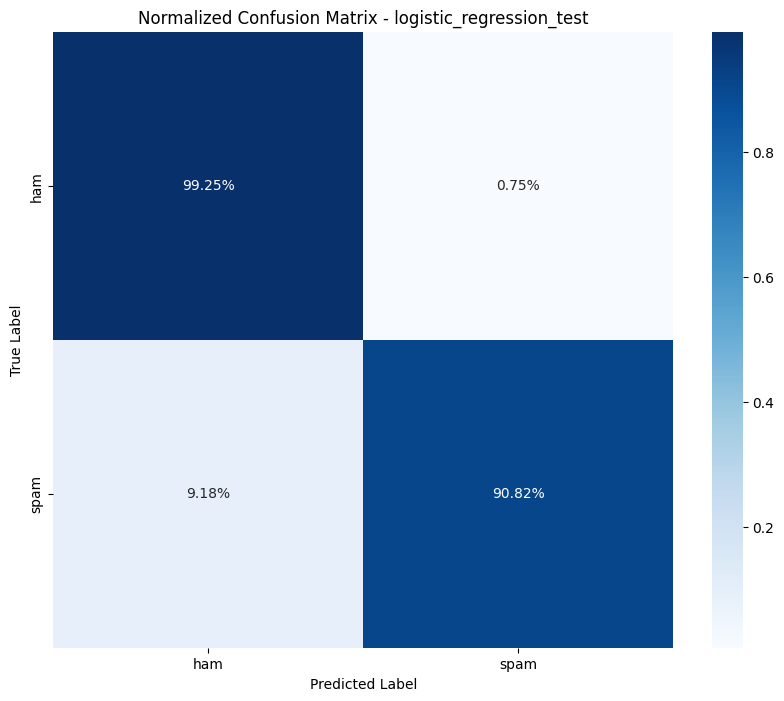

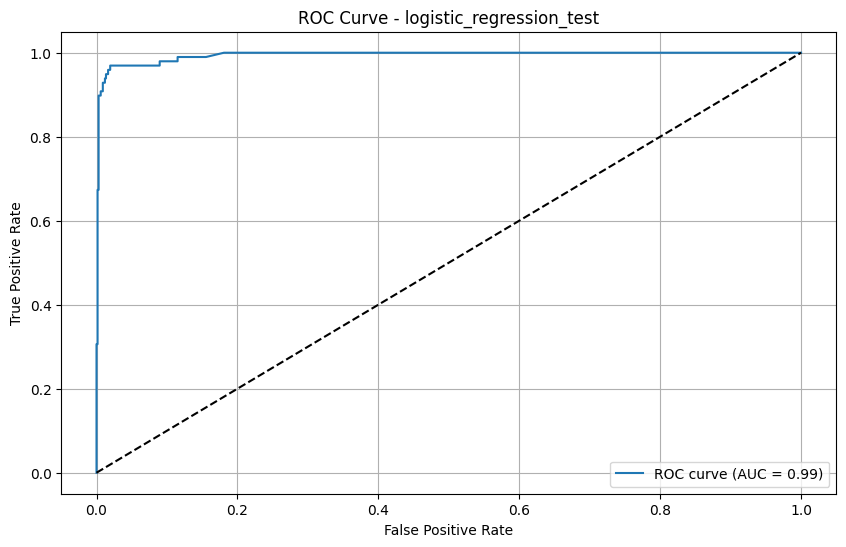

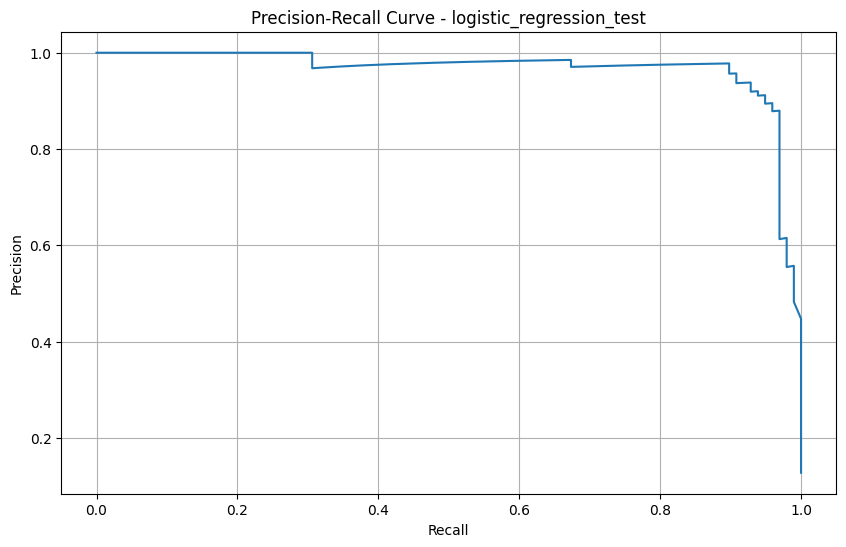


Results on logistic_regression_test set:
Accuracy: 0.9817

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       669
           1       0.95      0.91      0.93        98

    accuracy                           0.98       767
   macro avg       0.97      0.95      0.96       767
weighted avg       0.98      0.98      0.98       767



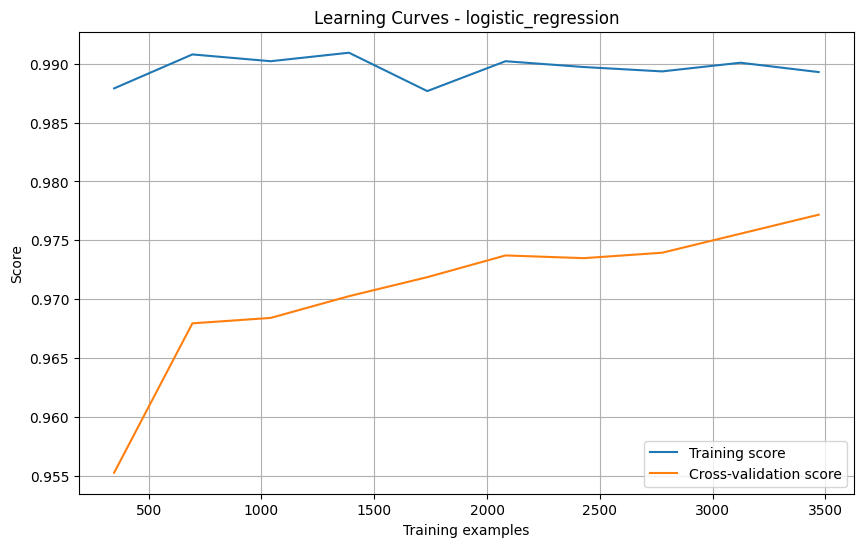


Model Fit Analysis:
Train score: 0.9887
Test score: 0.9817


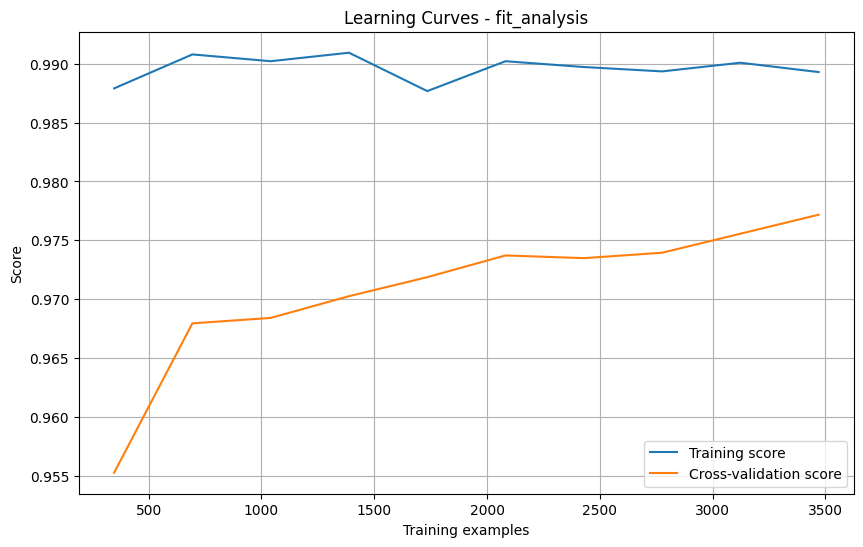

 67%|████████████████████▋          | 4/6 [00:23<00:12,  6.22s/it]


Training neural_network...


/shared/home/model/miniconda3/envs/dhruv/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


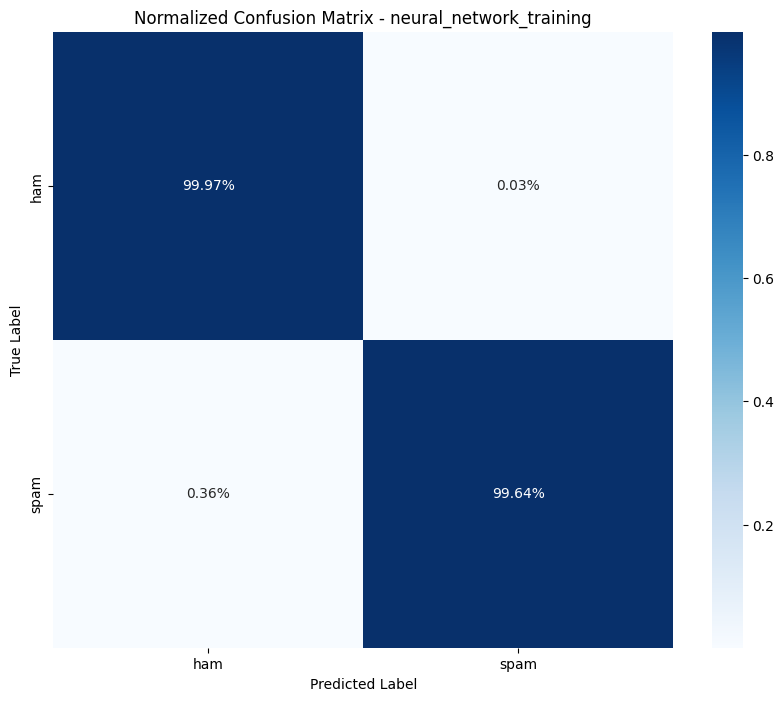

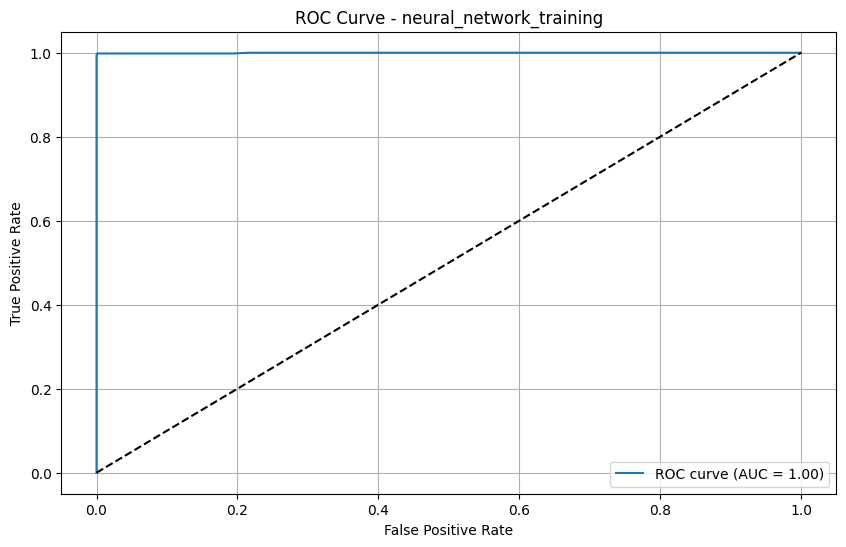

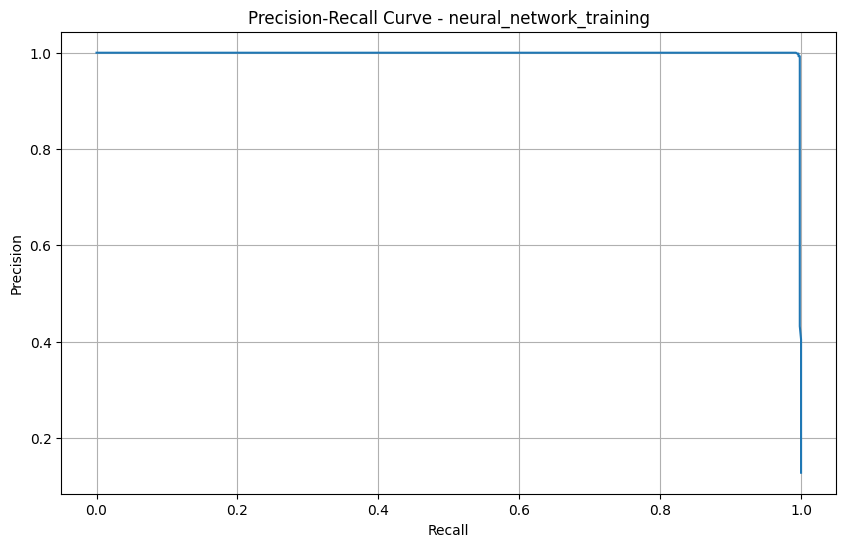


Results on neural_network_training set:
Accuracy: 0.9993

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3783
           1       1.00      1.00      1.00       555

    accuracy                           1.00      4338
   macro avg       1.00      1.00      1.00      4338
weighted avg       1.00      1.00      1.00      4338



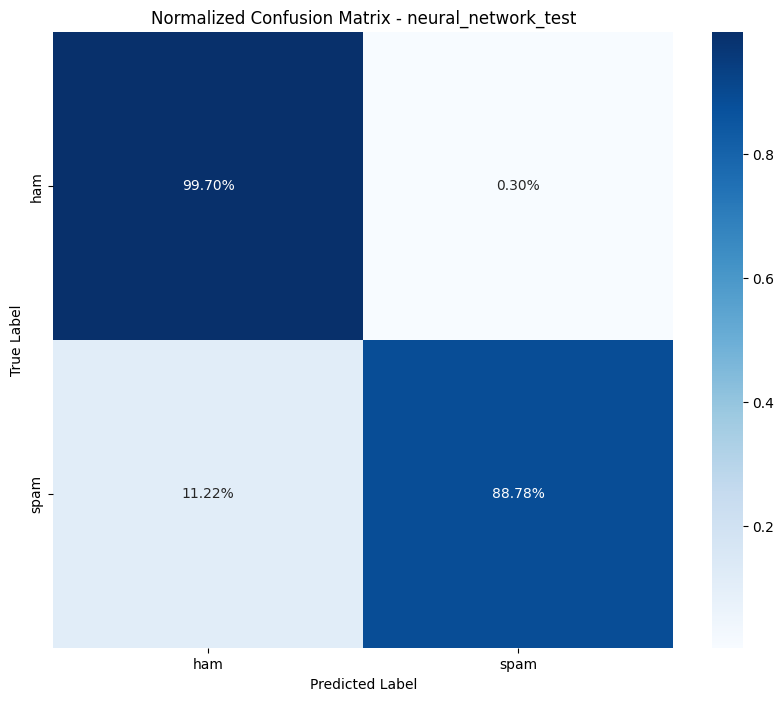

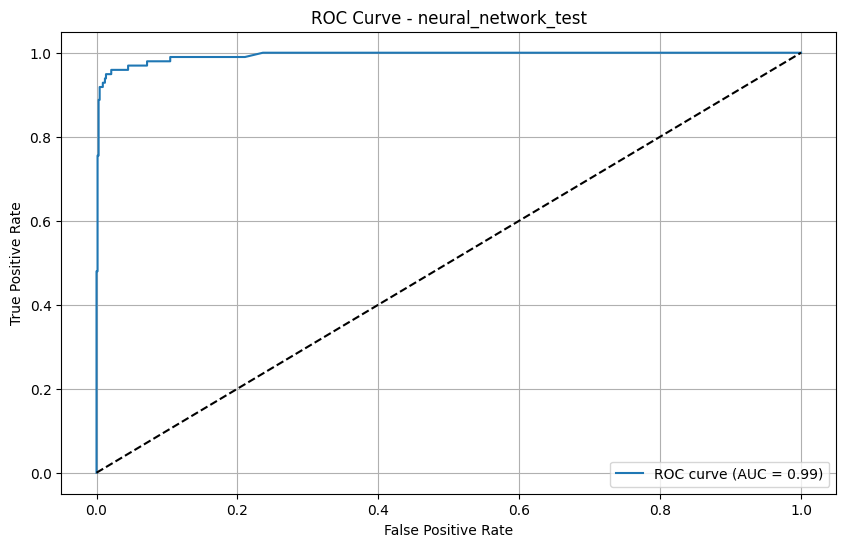

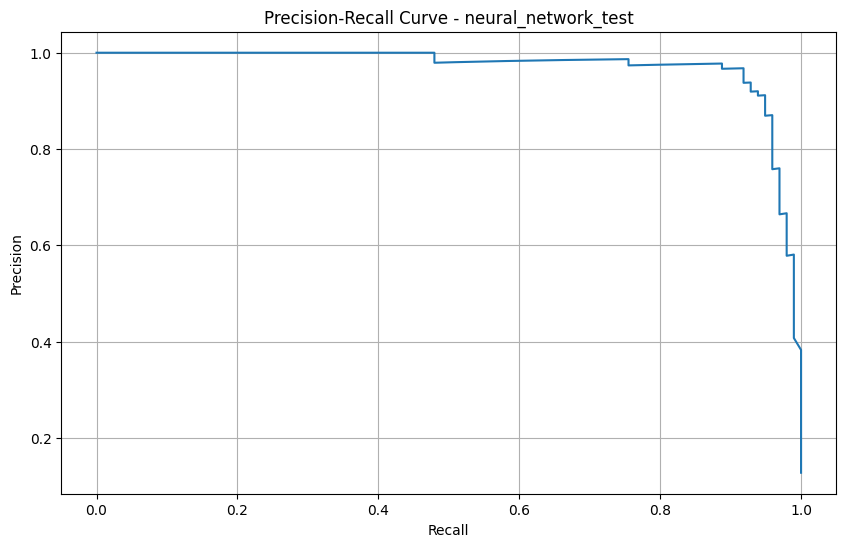


Results on neural_network_test set:
Accuracy: 0.9831

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       669
           1       0.98      0.89      0.93        98

    accuracy                           0.98       767
   macro avg       0.98      0.94      0.96       767
weighted avg       0.98      0.98      0.98       767



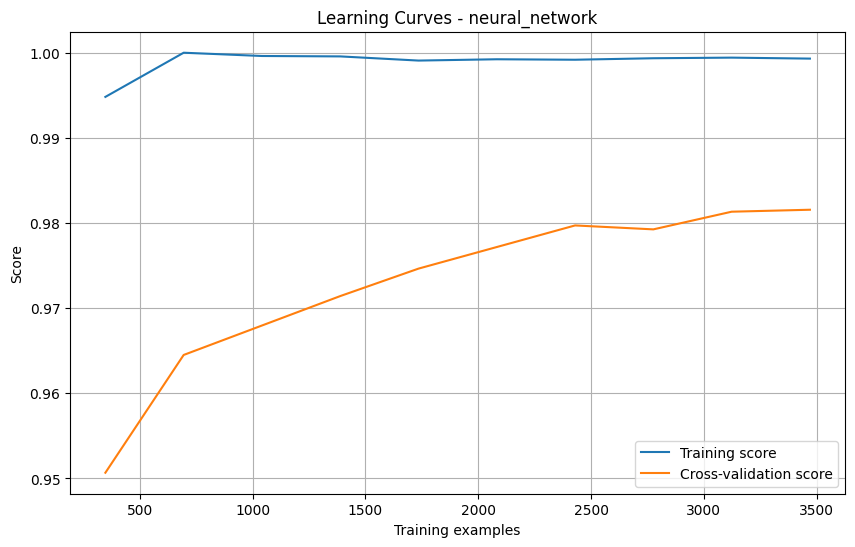


Model Fit Analysis:
Train score: 0.9993
Test score: 0.9831


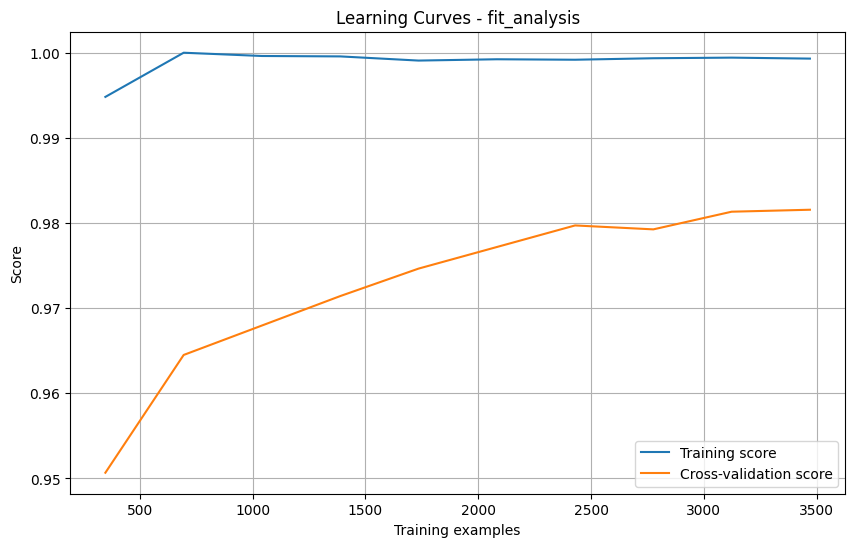

 83%|█████████████████████████▊     | 5/6 [04:41<01:37, 97.16s/it]


Training random_forest...


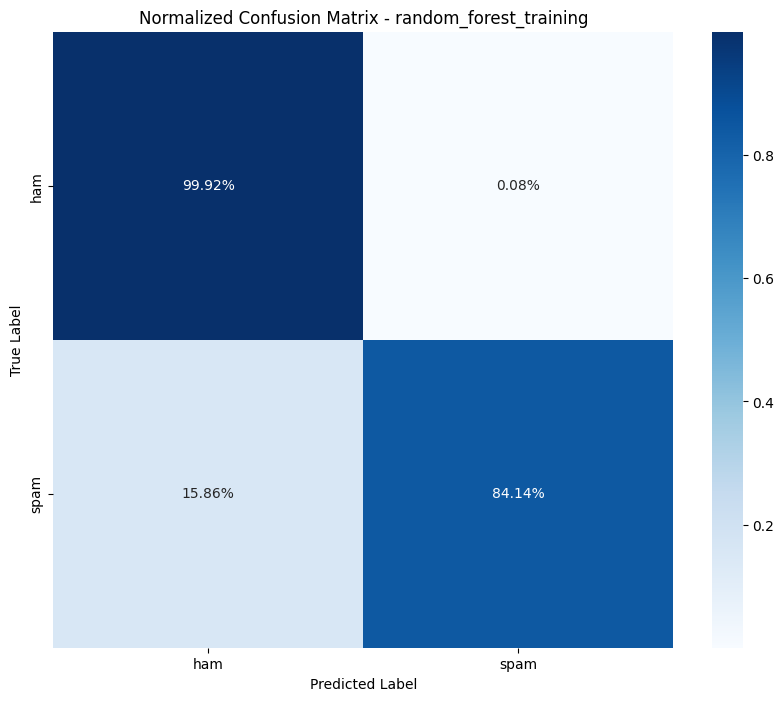

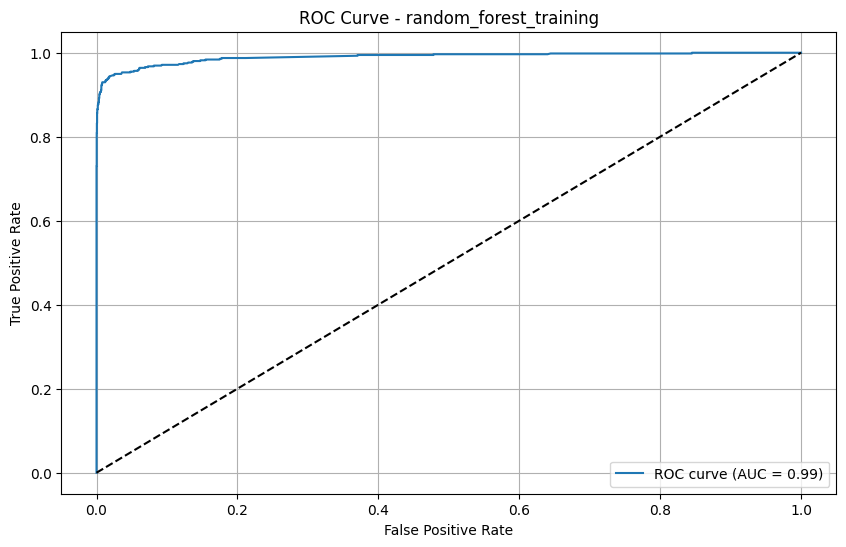

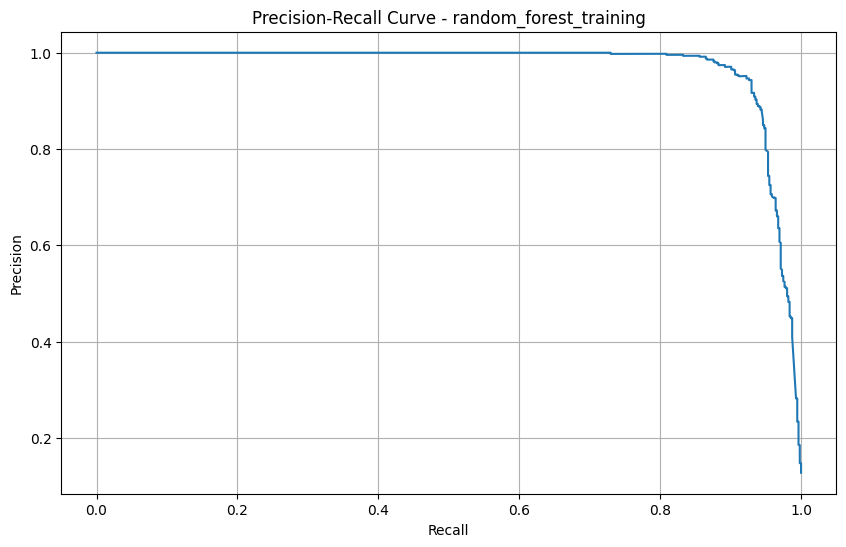


Results on random_forest_training set:
Accuracy: 0.9790

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3783
           1       0.99      0.84      0.91       555

    accuracy                           0.98      4338
   macro avg       0.99      0.92      0.95      4338
weighted avg       0.98      0.98      0.98      4338



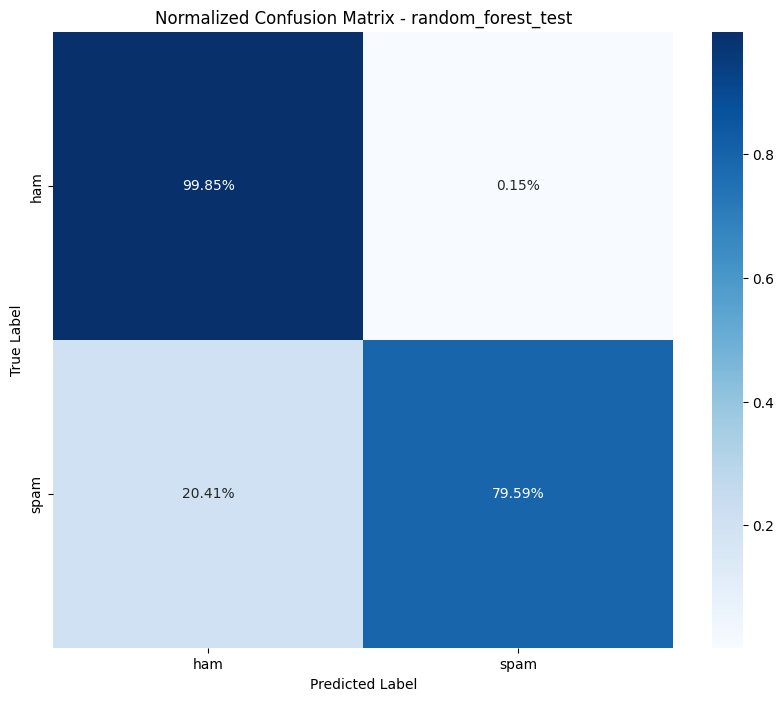

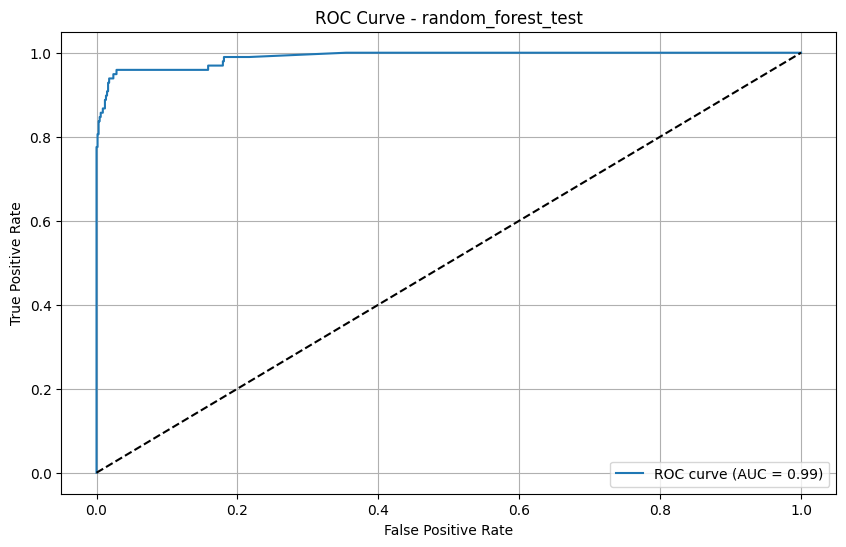

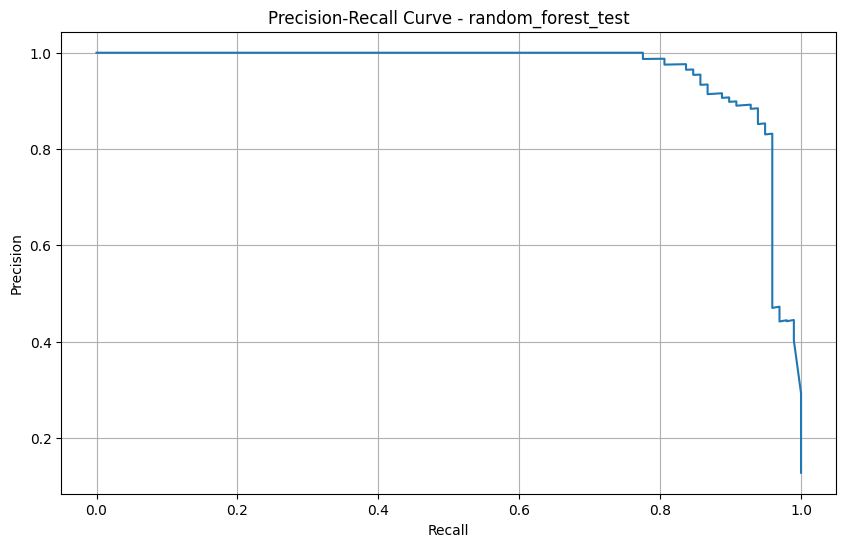


Results on random_forest_test set:
Accuracy: 0.9726

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       669
           1       0.99      0.80      0.88        98

    accuracy                           0.97       767
   macro avg       0.98      0.90      0.93       767
weighted avg       0.97      0.97      0.97       767



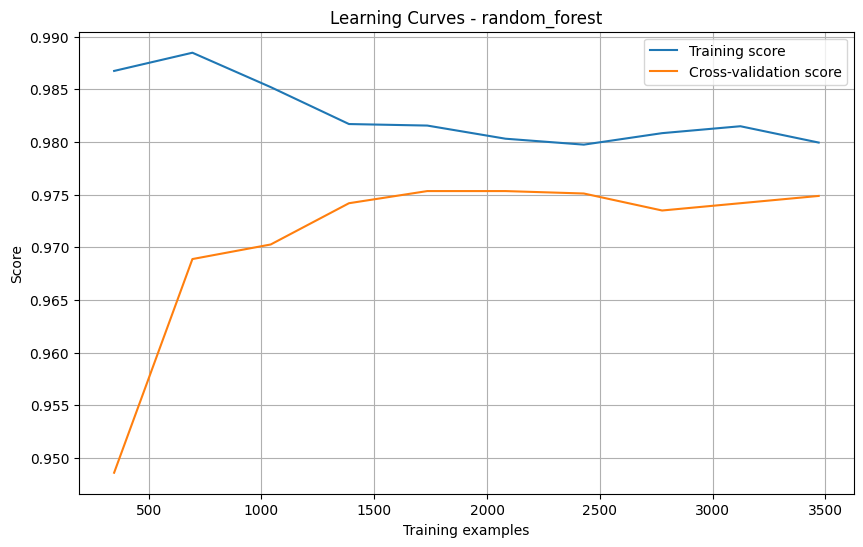


Model Fit Analysis:
Train score: 0.9790
Test score: 0.9726


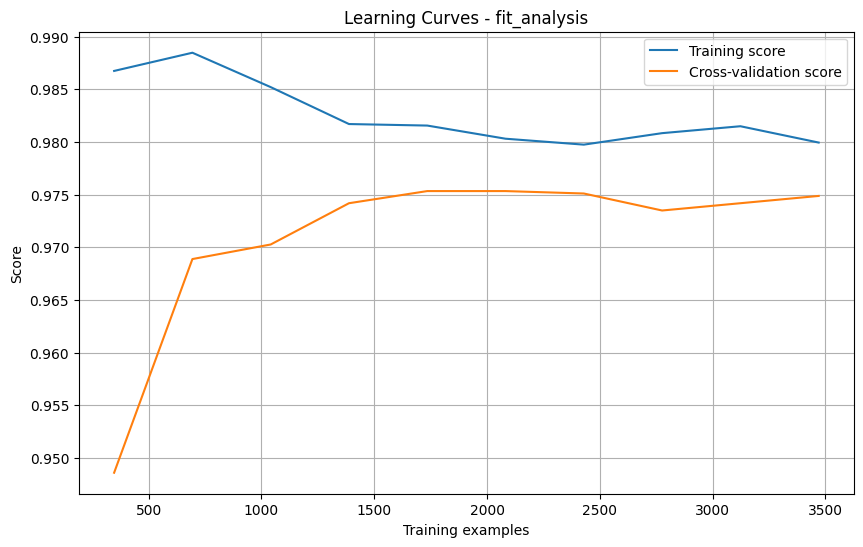

100%|███████████████████████████████| 6/6 [04:49<00:00, 48.25s/it]


Model Performance Summary:

Model Rankings (sorted by test accuracy):
              Model  Train Accuracy  Test Accuracy
        naive_bayes        0.986399       0.985658
     neural_network        0.999308       0.983051
       bernoulli_nb        0.985708       0.981747
logistic_regression        0.988704       0.981747
            svm_rbf        0.999078       0.979140
      random_forest        0.979023       0.972621

Best model (naive_bayes) saved as 'final_model.pkl'
Best test accuracy: 0.9857

Analyzing data drift...


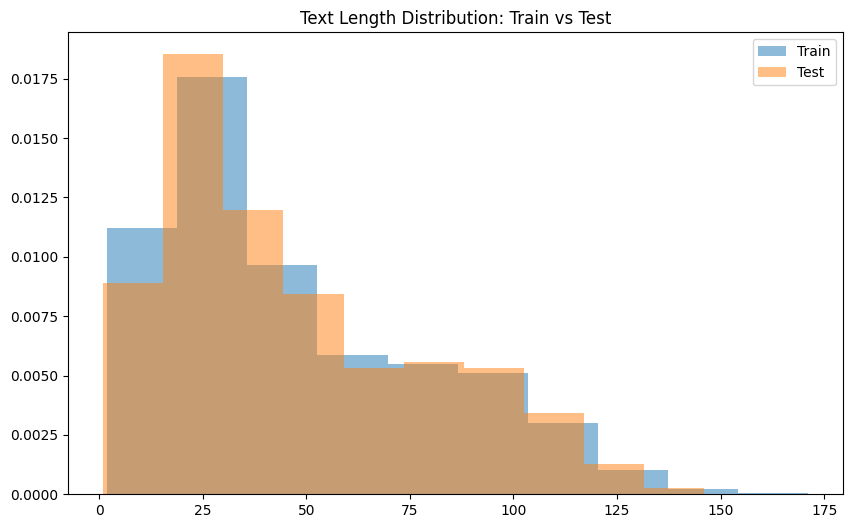

Vocabulary overlap between train and test: 29.10%

Training completed!


In [5]:
# Load the prepared data
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

# Initialize and run training
trainer = ModelTraining()
trainer.train_and_evaluate(train_df, val_df, test_df)

print("\nTraining completed!")

### Conclusion

- Best model naive_bayes
- Best test accuracy: 0.99